In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

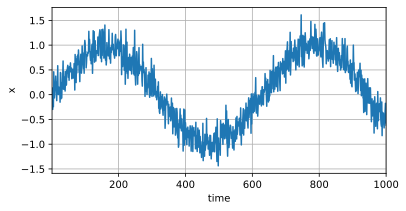

In [2]:
T = 1000 # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4
features = torch.zeros(T-tau,tau)
for i in range(tau):
    features[:,i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1,1))
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [4]:
features

tensor([[-0.1858,  0.1345, -0.2971, -0.0819],
        [ 0.1345, -0.2971, -0.0819, -0.2436],
        [-0.2971, -0.0819, -0.2436,  0.4612],
        ...,
        [-0.6705, -0.5093, -0.5708, -0.3218],
        [-0.5093, -0.5708, -0.3218, -0.1749],
        [-0.5708, -0.3218, -0.1749, -0.3444]])

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1))
    net.apply(init_weights)
    return net
# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
                f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.070241
epoch 2, loss: 0.062151
epoch 3, loss: 0.058275
epoch 4, loss: 0.056159
epoch 5, loss: 0.056805


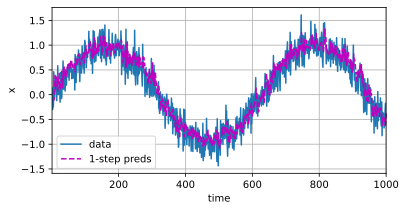

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
 [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
 'x', legend=['data', '1-step preds'], xlim=[1, 1000],
 figsize=(6, 3))

In [8]:
max_steps = 64

In [9]:
features = torch.zeros((T- tau- max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T- tau- max_steps + 1]
# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
     features[:, i] = net(features[:, i- tau:i]).reshape(-1)

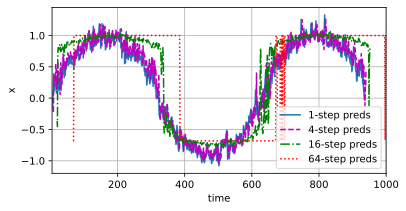

In [10]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i- 1: T- max_steps + i] for i in steps],
 [features[:, (tau + i- 1)].detach().numpy() for i in steps], 'time', 'x',
 legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
 figsize=(6, 3))

In [11]:
import collections
import re
from d2l import torch as d2l

In [12]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
 '090b5e7e70c295757f55df93cb0a180b9691891a')

In [13]:
def read_time_machine(): #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])
print(lines[0:10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the
['the time machine by h g wells', '', '', '', '', 'i', '', '', 'the time traveller for so it will be convenient to speak of him', 'was expounding a recondite matter to us his grey eyes shone and']


In [14]:
def tokenize(lines, token = 'word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
         print('错误：未知词元类型：' + token)

In [15]:
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [16]:
class Vocab: #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                            for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token)- 1
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    @property
    def unk(self): # 未知词元的索引为0
        return 0
    @property
    def token_freqs(self):
        return self._token_freqs
        
def count_corpus(tokens): #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [17]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [18]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [19]:
def load_corpus_time_machine(max_tokens=-1): #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [20]:
import random
import torch
from d2l import torch as d2l

In [21]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

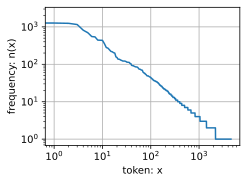

In [22]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
 xscale='log', yscale='log')

In [23]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [24]:
trigram_tokens = [triple for triple in zip(
 corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

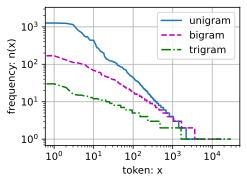

In [25]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
 ylabel='frequency: n(x)', xscale='log', yscale='log',
 legend=['unigram', 'bigram', 'trigram'])

In [26]:
import torch
from d2l import torch as d2l

In [27]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
print(X)
print(W_xh)
print(H)
print(W_hh)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 1.0985],
        [-1.1361],
        [-1.5541]])
tensor([[ 0.8080, -0.9341,  2.0704, -0.2947]])
tensor([[ 0.8628, -1.5001, -1.1066, -0.2674],
        [ 0.2292, -0.0602,  0.8665, -0.6119],
        [-0.7232,  0.0408, -1.0884, -1.5821]])
tensor([[ 0.1107, -3.4090,  0.5346,  1.2204],
        [-2.7972, -0.0086, -0.9820,  0.6181],
        [-0.2339, -0.9433,  0.2951, -1.4840],
        [-1.0681,  0.4808, -1.2874,  1.9453]])


tensor([[ 5.7236, -3.0392,  4.2263,  0.9240],
        [-0.2733, -0.8311, -1.1270, -1.8988],
        [ 0.4945,  4.1826, -1.9286, -1.8619]])

In [28]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [29]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [30]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [31]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [64]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab),num_hiddens)

In [68]:
state = torch.zeros((1,batch_size,num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [78]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens),
                        device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                    self.num_directions * self.rnn.num_layers,
                    batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                    self.num_directions * self.rnn.num_layers,
                    batch_size, self.num_hiddens), device=device))

In [80]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travelleroybbbbbbbb'

perplexity 1.3, 245113.0 tokens/sec on cuda:0
time travellerit s against reason said filbywa tha time travelle
travellerit roums in t lorlay ex scallloree git and centwer


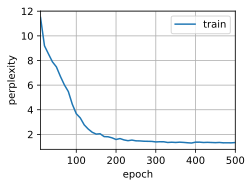

In [81]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)